### Question 1 (5 Marks)
In most DL applications, instead of training a model from scratch, you would use a model pre-trained on a similar/related task/dataset. From ```torchvision```, you can load **ANY ONE** [model](https://pytorch.org/vision/stable/models.html) (```GoogLeNet```, ```InceptionV3```, ```ResNet50```, ```VGG```, ```EfficientNetV2```, ```VisionTransformer``` etc.) pre-trained  on the ImageNet dataset. Given that ImageNet also contains many animal images, it stands to reason that using a model pre-trained on ImageNet maybe helpful for this task. 

You will load a pre-trained model and then fine-tune it using the naturalist data that you used in the previous question. Simply put, instead of randomly initialising the weigths of a network you will use the weights resulting from training the model on the ImageNet data (```torchvision``` directly provides these weights). Please answer the following questions:

- The dimensions of the images in your data may not be the same as that in the ImageNet data. How will you address this?

### Answer:

The dimensions of the iNaturalist images may not match the ImageNet dataset. To solve this, we need to resize the images of the iNaturalist dataset to a common resolution and then crop the centre to match the size of the ImageNet dataset. In the partA , I have done preprocessing of the dataset for training the CNN model, in which I used $transforms$ module from torchvision package to solve the inconsistent image sizes. After centre cropping, we will convert it to a tensor and normalise it.

```python
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
```


- ImageNet has $1000$ classes and hence the last layer of the pre-trained model would have $1000$ nodes. However, the naturalist dataset has only $10$ classes. How will you address this?

### Answer:

The ImageNet dataset has 1000 classes, but the iNaturalist dataset has only 10 classes. To solve this difference, we can replace the final fully connected layer with new layer that has only 10 nodes.

```python
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)
```

(Note: This question is only to check the implementation. The subsequent questions will talk about how exactly you will do the fine-tuning.)

### Question 2 (5 Marks)
You will notice that ```GoogLeNet```, ```InceptionV3```, ```ResNet50```, ```VGG```, ```EfficientNetV2```, ```VisionTransformer``` are very huge models as compared to the simple model that you implemented in Part A. Even fine-tuning on a small training data may be very expensive. What is a common trick used to keep the training tractable (you will have to read up a bit on this)? Try different variants of this trick and fine-tune the model using the iNaturalist dataset. For example, '_______'ing all layers except the last layer, '_______'ing upto $k$ layers and  '_______'ing the rest. Read up on pre-training and fine-tuning to understand what exactly these terms mean.

Write down the at least $3$ different strategies that you tried (simple bullet points would be fine).

Answer:
In order to reduce the cost of training, we can use the following three strategies:
- Feature Extraction: We can freeze all the layers except the last layer, so that we can preserve all the low level features and reduce the memory usage and for quick training
- Partial Finetuning: We can freeze the network parameters except for the last "k" layers, so that we can fine-tune much deeper. This is improve model performance on the current dataset. We can do this if we have enough compute to train efficiently. 
- Full Finetuning with discriminative learning rate: We can fine-tune the full network if we have enough compute. while doing this, we can have the learning rate of the early layers of the pretrained network lower, and have slightly larger learning rates for the last few layers. This way, the updation of the parameters in the early layers will happen slowly, kind of slowing down the "unlearning" of the trained parameters. But, I guess, this would be a bit expensive strategy. 

### Question 3 (10 Marks)
Now fine-tune the model using **ANY ONE** of the listed strategies that you discussed above. Based on these experiments write down some insightful inferences comparing training from scratch and fine-tuning a large pre-trained model.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import wandb
import os

wandb.init(project='assignment_2', name='googlenet_frozen_early_layers')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

data = '/mnt/e_disk/DA24S008/DA6401_Assignment_2/dataset/inaturalist_12K'
trainset = ImageFolder(root=os.path.join(data, 'train'), transform=transform)
testset = ImageFolder(root=os.path.join(data, 'val'), transform=transform)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])

batch_size = 64
trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

for idx, child in enumerate(model.children()):
    print(idx, child)

for param in model.parameters():
    param.requires_grad = False
for param in model.inception5b.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, len(trainset.classes))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total

    wandb.log({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    })

    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

torch.save(model.state_dict(), "googlenet_finetuned.pth")
wandb.save("googlenet_finetuned.pth")

model.eval()
test_loss, test_correct, test_total = 0.0, 0, 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_loss /= test_total
test_acc = test_correct / test_total

print(f"\n Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
wandb.log({'test_loss': test_loss, 'test_acc': test_acc})


0 BasicConv2d(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)
1 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
2 BasicConv2d(
  (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)
3 BasicConv2d(
  (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)
4 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
5 Inception(
  (branch1): BasicConv2d(
    (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch2): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(192, 96,

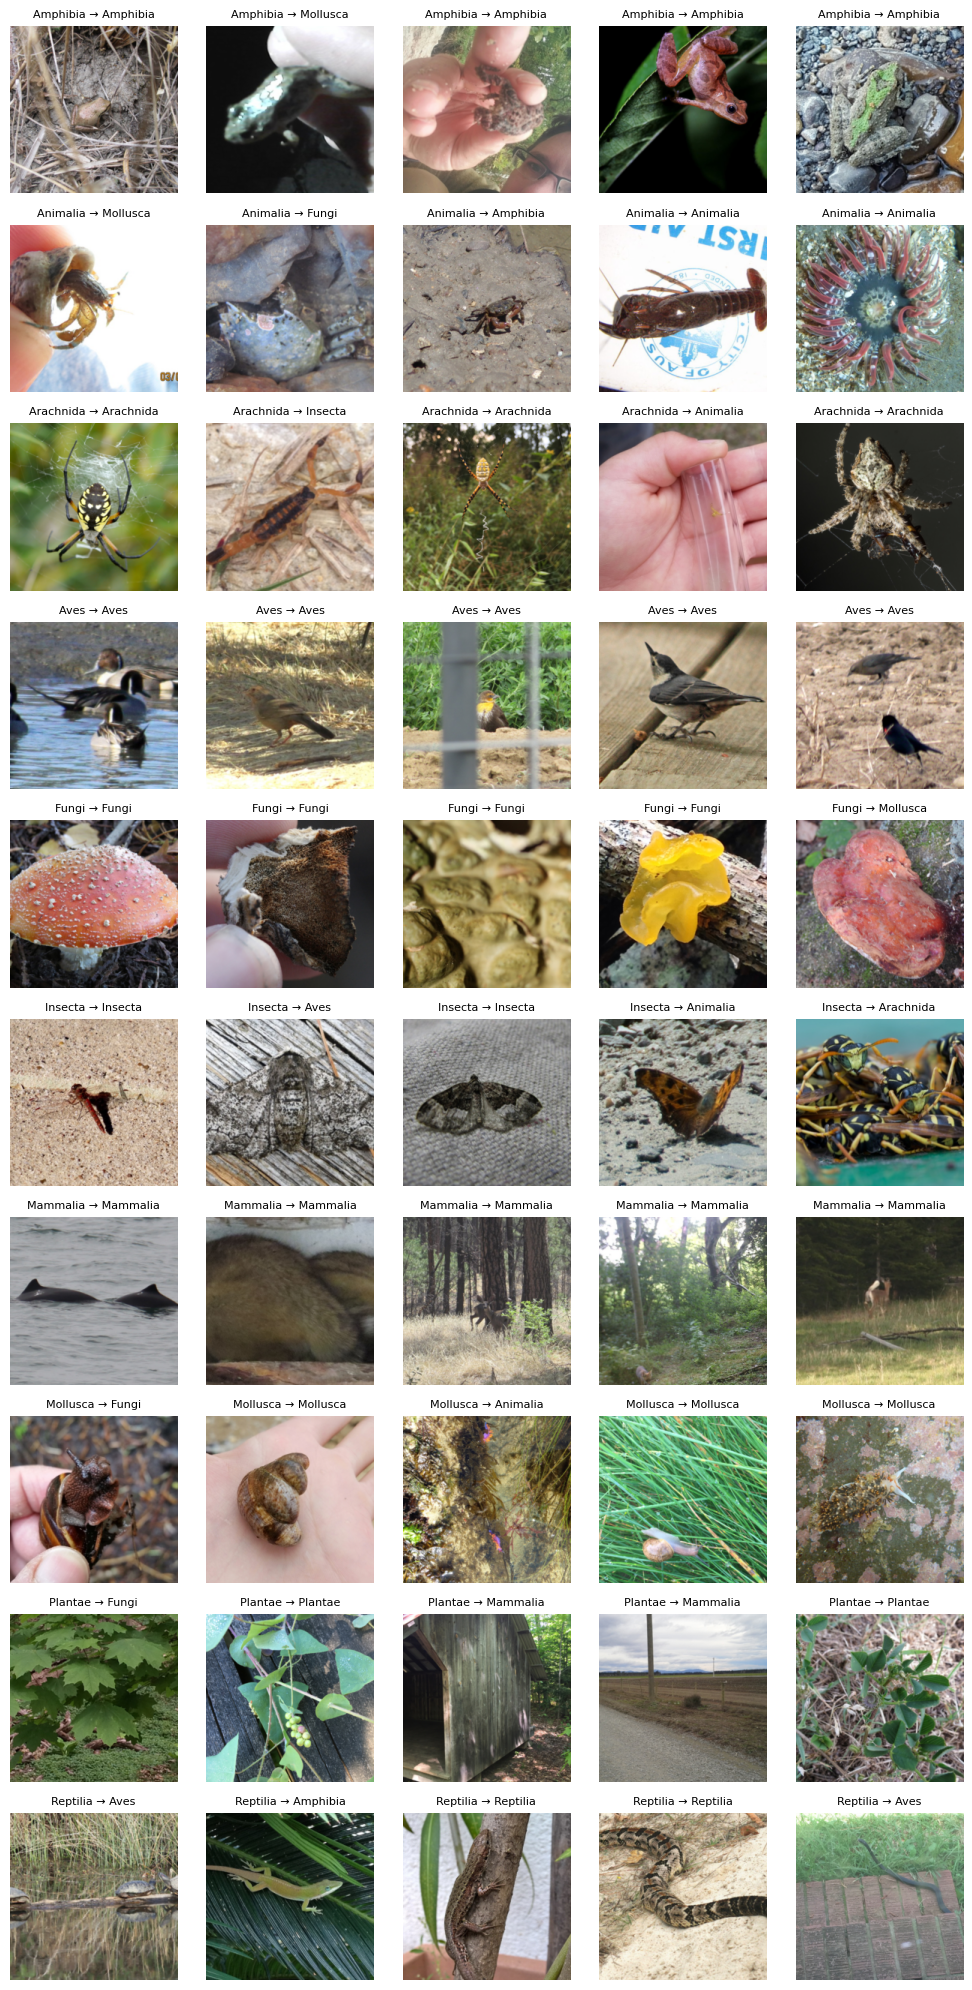

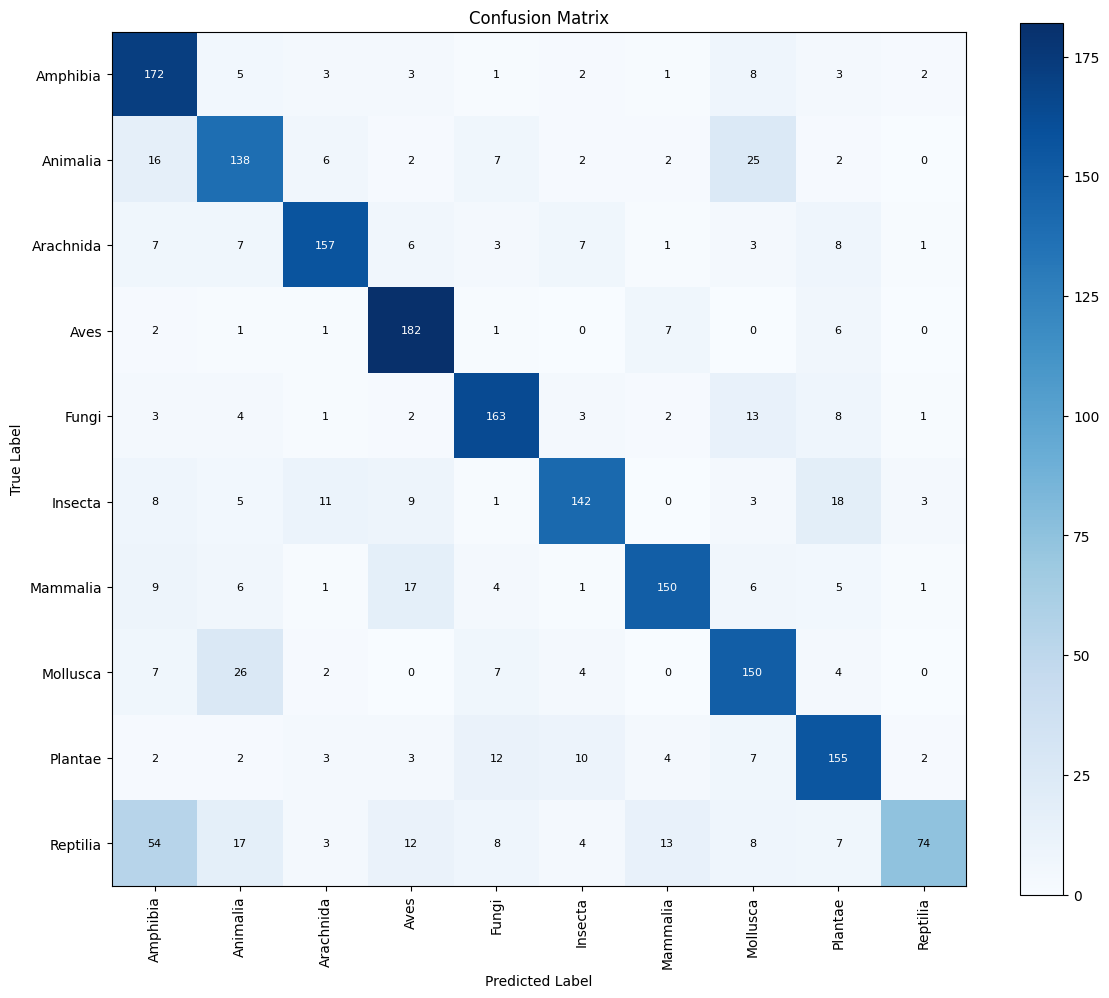

In [11]:
# The below code is only testing and visualizing the test results as images and confusion matrix. 

import matplotlib.pyplot as plt
import numpy as np

def imshow(img_tensor):
    img_tensor = img_tensor.cpu()
    img_tensor = img_tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
                              torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    return img_tensor.clamp(0, 1)


# We can change the number of images per class for visualization
samples_per_class = 5
collected = {cls: [] for cls in range(len(testset.classes))}

num_classes = len(testset.classes)
conf_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int32)

for img, label in testset:
    if len(collected[label]) < samples_per_class:
        collected[label].append((img, label))
    if all(len(v) == samples_per_class for v in collected.values()):
        break

all_images = []
all_labels = []
for cls in collected:
    for img, label in collected[cls]:
        all_images.append(img)
        all_labels.append(label)

images_batch = torch.stack(all_images).to(device)

model.eval()
with torch.no_grad():
    outputs = model(images_batch)
    _, preds = torch.max(outputs, 1)

num_classes = len(testset.classes)
plt.figure(figsize=(samples_per_class * 2, num_classes * 2))

for idx in range(len(images_batch)):
    img = imshow(all_images[idx])
    actual = testset.classes[all_labels[idx]]
    predicted = testset.classes[preds[idx].item()]

    plt.subplot(num_classes, samples_per_class, idx + 1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.title(f'{actual} → {predicted}', fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
            conf_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(12, 10))
plt.imshow(conf_matrix.numpy(), interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, testset.classes, rotation=90)
plt.yticks(tick_marks, testset.classes)

thresh = conf_matrix.max().item() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        count = conf_matrix[i, j].item()
        plt.text(j, i, str(count),
                 ha="center", va="center",
                 color="white" if count > thresh else "black",
                 fontsize=8)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
